# Repeated Cross Validation

In [169]:
import numpy as np
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import os
import random
import tqdm
import matplotlib.pyplot as plt

### Loading and preparing the dataset

In [7]:
df = pd.read_csv('bank-full.csv', sep =';')

In [13]:
df.shape

(45211, 17)

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
import preprocessing

In [10]:
df_enc = preprocessing.encode(df)

In [14]:
df_enc.shape

(45211, 11)

In [11]:
df_enc.head()

,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,marital_divorced,marital_married,marital_single,balance,pdays,previous,campaign
0,0,0,0,1,0,1,0,0.007088,-0.04709,-0.00211,-0.028449
1,0,0,0,1,0,0,1,-0.012105,-0.04709,-0.00211,-0.028449
2,0,0,0,1,0,1,0,-0.012350,-0.04709,-0.00211,-0.028449
3,0,0,0,1,0,1,0,0.001305,-0.04709,-0.00211,-0.028449
4,0,0,0,1,0,0,1,-0.012359,-0.04709,-0.00211,-0.028449


In [16]:
df_y = df.y.map({'yes': 1, 'no': 0})

### Performing repeated cross validation

In [94]:
def perform_repeated_cv(X, y , model):
    #set random seed for repeartability
    random.seed(1)

    #set the number of repetitions
    n_reps = 50

    # perform repeated cross validation
    accuracy_scores = np.zeros(n_reps)
    precision_scores=  np.zeros(n_reps)
    recall_scores =  np.zeros(n_reps)

    for u in tqdm.tqdm(range(n_reps)):

        #randomly shuffle the dataset
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices] #dataset has been randomly shuffled

        #initialize vector to keep predictions from all folds of the cross-validation
        y_predicted = np.zeros(y.shape)

        #perform 10-fold cross validation
        kf = KFold(n_splits=5 , random_state=142)
        for train, test in kf.split(X):

            #split the dataset into training and testing
            X_train = X[train]
            X_test = X[test]
            y_train = y[train]
            y_test = y[test]

            #standardization
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)

            #train model
            clf = model
            clf.fit(X_train, y_train)

            #make predictions on the testing set
            y_predicted[test] = clf.predict(X_test)

        #record scores
        accuracy_scores[u] = accuracy_score(y, y_predicted)
        precision_scores[u] = precision_score(y, y_predicted)
        recall_scores[u]  = recall_score(y, y_predicted)

    #return all scores
    return accuracy_scores, precision_scores, recall_scores

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [96]:
acc_sc, prec_sc, rec_sc = perform_repeated_cv(df_enc.values, df_y.values, RandomForestClassifier())

100%|██████████| 50/50 [01:28<00:00,  1.74s/it]


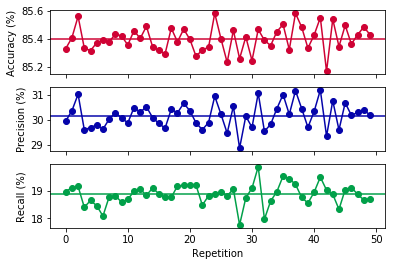

In [97]:
fig, axes = plt.subplots(3,1,sharex=True)
axes[0].plot(100*acc_sc, color = 'xkcd:cherry', marker= 'o', linestyle='-')
axes[0].set_ylabel('Accuracy (%)')
axes[0].axhline(100*np.mean(acc_sc), color = 'xkcd:cherry')
axes[1].plot(100*prec_sc, color = 'xkcd:royal blue' , marker = 'o', linestyle='-')
axes[1].set_ylabel('Precision (%)')
axes[1].axhline(100*np.mean(prec_sc), color = 'xkcd:royal blue')
axes[2].plot(100*rec_sc, color = 'xkcd:emerald' , marker = 'o', linestyle='-')
axes[2].axhline(100*np.mean(rec_sc), color = 'xkcd:emerald')
axes[2].set_ylabel('Recall (%)')
plt.xlabel('Repetition')
plt.show()

By the way, repeated cross validation is already implemented in sklearn.

In [175]:
from sklearn.pipeline import Pipeline

stsc = StandardScaler()
classify = Pipeline([('scaling', stsc),
                     ('classifying', RandomForestClassifier())])
rkf = RepeatedKFold(n_splits = 5, n_repeats = 50)

acc_sc_1 = []
prec_sc_1 = []
rec_sc_1 = []

for train_index, test_index in rkf.split(df_enc):
    classify.fit(df_enc.loc[train_index], df_y.loc[train_index])
    df_pred = classify.predict(df_enc.loc[test_index]) 
    acc_sc_1.append(np.mean(accuracy_score(df_pred, df_y.loc[test_index])))
    prec_sc_1.append(precision_score(df_pred, df_y.loc[test_index]))
    rec_sc_1.append(recall_score(df_pred, df_y.loc[test_index]))

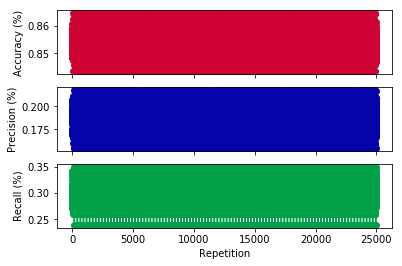

In [176]:
fig, axes = plt.subplots(3,1,sharex=True)
axes[0].plot(100*acc_sc_1, color = 'xkcd:cherry', marker= 'o', linestyle='-')
axes[0].set_ylabel('Accuracy (%)')
#axes[0].axhline(100*np.mean(acc_sc_1), color = 'xkcd:cherry')
axes[1].plot(100*prec_sc_1, color = 'xkcd:royal blue' , marker = 'o', linestyle='-')
axes[1].set_ylabel('Precision (%)')
#axes[1].axhline(100*np.mean(prec_sc_1), color = 'xkcd:royal blue')
axes[2].plot(100*rec_sc_1, color = 'xkcd:emerald' , marker = 'o', linestyle='-')
#axes[2].axhline(100*np.mean(rec_sc_1), color = 'xkcd:emerald')
axes[2].set_ylabel('Recall (%)')
plt.xlabel('Repetition')
plt.show()

100%|██████████| 50/50 [00:21<00:00,  2.22it/s]


Maximum accuracy 89.28 at C = 0.00910


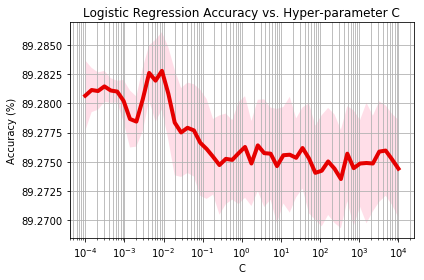

In [168]:
#set up the parameter sweep
c_sweep =  np.power(10, np.linspace(-4,4,50))

#perform repeated cross-validation by sweeping the parameter
accuracy_parameter_sweep = [] # keep scores here
std_parameter_sweep = [] #keep parameters in here
for c in c_sweep:

    #perform repeated cross-validation
    accuracy_scores, precision_scores, recall_scores = perform_repeated_cv(df_enc.values, df_y.values ,  LogisticRegression(C=c) )

    ##append scores
    accuracy_parameter_sweep.append(np.mean(100*accuracy_scores))
    std_parameter_sweep.append(np.std(100*accuracy_scores))


#plot C vs. accuracy
plt.fill_between(c_sweep , np.array(accuracy_parameter_sweep) - np.array(std_parameter_sweep) ,
                 np.array(accuracy_parameter_sweep) + np.array(std_parameter_sweep) , facecolor = 'xkcd:light pink', alpha=0.7)
plt.semilogx(c_sweep,accuracy_parameter_sweep , color= 'xkcd:red' , linewidth=4)
plt.xlabel('C')
plt.ylabel('Accuracy (%)')
plt.title('Logistic Regression Accuracy vs. Hyper-parameter C')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()
print('Maximum accuracy {:.2f} at C = {:.5f}'.format(max(accuracy_parameter_sweep), c_sweep[np.argmax(accuracy_parameter_sweep)]))


### Exercises

In [ ]:
1. Try to optimize hyperparameters 